In [6]:
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import os
import json
import tqdm
import matplotlib.ticker as ticker
sns.set()

In [7]:
import sys
sys.path.insert(0, '../')
from model.seq2seq import Seq2Seq, tf
from model.decoding_techniques import BeamSearchDecoder, GreedyDecoder, NucleusDecoder
from utils.processing_utils import *

1 Physical GPUs, 1 Logical GPUs


# Loading and preparation

In [8]:
data_path = '../processed_data'
mode = 'custom'
all_train = True
with open(os.path.join(data_path,'glove_embeddings_trained_opensubs.npy'), 'rb') as f:
        final_embeddings = np.load(f)
        
with open(os.path.join(data_path,'token_mapping_opensubs.json'), 'r') as f:
    token_mapping = json.load(f)

with open(os.path.join(data_path,'data_opensubs.npy'), 'rb') as f:
    data = np.load(f,allow_pickle=True) 
    
with open(os.path.join(data_path,'missing_in_glove_trained_opensubs.npy'), 'rb') as f:
        missing = np.load(f)

In [9]:
missing_idx = [token_mapping[i] for i in missing]

In [10]:
len(data)

1617140

In [11]:
inverse_token_mapping = dict((v,k) for k,v in token_mapping.items())
pad_token = inverse_token_mapping[0]
start_token = inverse_token_mapping[1]
end_token = inverse_token_mapping[2]
unk_token = inverse_token_mapping[3]

In [12]:
data = np.array(data)

In [13]:
X, y = data[:,0], data[:,1]

In [14]:
def map_to_ids(x, mapping, end_token=None, start_token=None, padding_token=None, max_len=None, 
              return_len=False):
  if isinstance(x, str):
    x = x.split(' ')
  max_len = max_len if max_len else len(x)
  length = len(x)
  if start_token:
    x = [start_token] + x
  sent_ids = [mapping[word] for word in x[:max_len]]
  if max_len>len(x):
      if end_token:
        sent_ids.append(mapping[end_token])
      if padding_token:
        sent_ids += [mapping[padding_token]]*(max_len-len(sent_ids))
      if return_len:
          return sent_ids,length+1
      else:
          return sent_ids
  if end_token:
    sent_ids[-1] = mapping[end_token]
  if return_len:
      return sent_ids, max_len
  else:
      return sent_ids


In [15]:
max_len_tokens = 10

In [31]:
if all_train:
    X_train_enc = np.array([map_to_ids(i, token_mapping, end_token, None, pad_token, max_len_tokens) for i in X])
    X_train_dec = np.array([map_to_ids(i, token_mapping, None, start_token, pad_token, max_len_tokens) for i in y])
    y_train, len_train = zip(*[map_to_ids(i, token_mapping, end_token, None, pad_token, max_len_tokens, return_len=True) for i in y])
    y_train, len_train = np.array(y_train), np.array(len_train)

In [32]:
X_train_dec[0], y_train[0], len_train[0]

(array([  1, 602,  14,   0,   0,   0,   0,   0,   0,   0]),
 array([602,  14,   2,   0,   0,   0,   0,   0,   0,   0]),
 3)

# Building a model

In [16]:
final_embeddings.shape

(50004, 100)

In [17]:
seq2seq = Seq2Seq(token_mapping, 
         pad_token=token_mapping[pad_token],
         end_token=token_mapping[end_token],
         start_token=token_mapping[start_token],
         max_len=max_len_tokens,
         embeddings=final_embeddings,
         embedding_prefix=mode,
         missing_tokens=np.array(missing_idx).astype(np.int32),
                  dropout_prob=0.2,
                  path_decoder='decoder_all_data_opensubs.h5',
                  path_encoder='encoder_all_data_opensubs.h5'
        )

# Training a model 

In [33]:
train_data = tf.data.Dataset.from_tensor_slices((X_train_enc, X_train_dec, y_train, len_train))
if not all_train:
    val_data = tf.data.Dataset.from_tensor_slices((X_test_enc, X_test_dec, y_test, len_test))
else:
    val_data = None

In [34]:
batch_size = 256
num_epochs = 68
epochs_patience = 10

In [35]:
seq2seq.fit(train_data,
            validation_dataset=val_data,
            steps_per_epoch=X_train_enc.shape[0]//batch_size,
            batch_size=batch_size,
            num_epochs=num_epochs,
            epochs_patience=epochs_patience,
            experiment_name='opensubs')

Dir models already exists


  0%|          | 0/68 [00:30<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
seq2seq.save_models(decoder_path='decoder_all_data_opensubs.h5',
                   encoder_path='encoder_all_data_opensubs.h5')

# Testing predictions and other helpful stuff

In [20]:
import sys
sys.path.insert(0, '../')
from utils.model_utils import plot_attention

In [18]:
def process(x, unk_token):
  res = []
  for i in x.split(' '):
    if token_mapping.get(i):
      res.append(i)
    elif token_mapping.get(i.lower()):
      res.append(i.lower())
    else:
      res.append(unk_token)
  return res

In [19]:
def give_answer(decoder, sentence, inverse_token_mapping, pad_unk=True, process_sentence=True, len_output=50,
               beam_size=3,
              top_p=0.95,
               beam_search=False,
               nucleus_sampling = False,
               show_attention=False):
      if process_sentence:
        cleaned_sentence = uncover_reduction(clean_bad_chars(sentence))
        unk_token = pad_token if pad_unk else "<unk>"
        processed_sentence = process(cleaned_sentence, unk_token)
        mapped_sentence = map_to_ids(processed_sentence, token_mapping, end_token, padding_token=pad_token, max_len=max_len_tokens)
      else:
        mapped_sentence = sentence
      if beam_search:
        prediction = decoder.decode(mapped_sentence, beam_size)
      elif nucleus_sampling:
        prediction = decoder.decode(mapped_sentence, len_output, top_p)
      else:
          prediction = decoder.decode(mapped_sentence, len_output, show_attention)
      if show_attention and not beam_search:
        prediction, attention = prediction
      answer = " ".join([inverse_token_mapping.get(i) for i in prediction]).capitalize()
      if show_attention and not beam_search:
            plot_attention(attention,sentence.split(' '), answer.split(' '))
      return answer

In [21]:
greedy_decoder = GreedyDecoder(decoder=seq2seq.decoder,
             encoder=seq2seq.encoder,
             max_len=max_len_tokens,
             start_token=token_mapping[start_token],
             end_token=token_mapping[end_token])

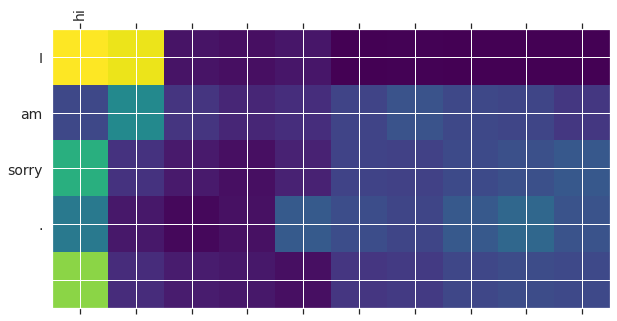

'I am sorry .'

In [23]:
give_answer(greedy_decoder, 'hi', inverse_token_mapping, show_attention=True)

In [24]:
beam_search_decoder = BeamSearchDecoder(decoder=seq2seq.decoder, 
                 encoder=seq2seq.encoder,
                 max_len=max_len_tokens,
                 start_token=token_mapping[start_token],
                 end_token=token_mapping[end_token])

In [25]:
give_answer(beam_search_decoder, 'hi ', inverse_token_mapping, show_attention=False,
           beam_search=True)

'I am sorry .'

In [26]:
nucleus_decoder = NucleusDecoder(decoder=seq2seq.decoder, 
                 encoder=seq2seq.encoder,
                 max_len=max_len_tokens,
                 start_token=token_mapping[start_token],
                 end_token=token_mapping[end_token])

In [27]:
give_answer(nucleus_decoder, 'hi', inverse_token_mapping, nucleus_sampling=True, top_p=0.75)

'So long up ?'

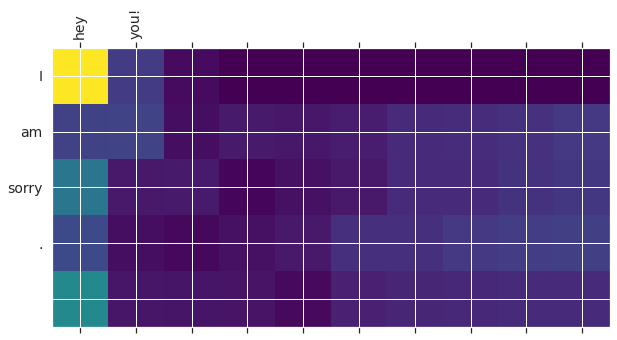

------------------------------
Test replica : hey you!
Bot greedy answer : I am sorry .
Bot beam search answer : Hey !
Bot nucleus answr : It
------------------------------


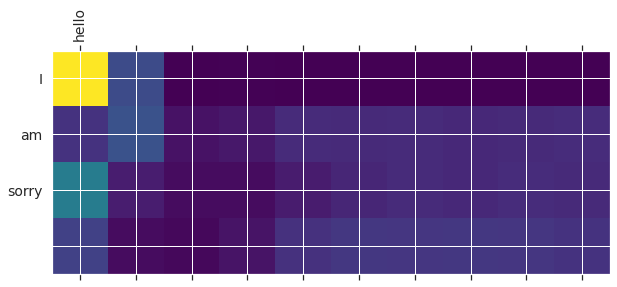

------------------------------
Test replica : hello
Bot greedy answer : I am sorry
Bot beam search answer : Hello hello hello .
Bot nucleus answr : Iil buy you something up i need the city
------------------------------


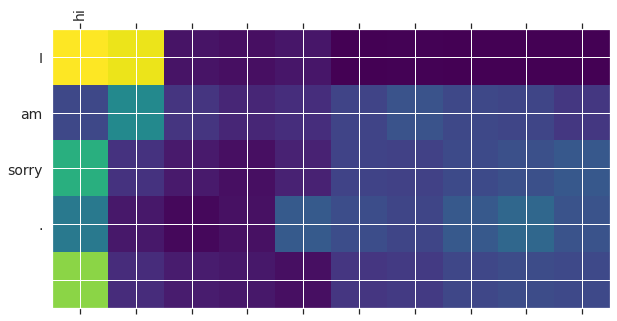

------------------------------
Test replica : hi
Bot greedy answer : I am sorry .
Bot beam search answer : I am sorry .
Bot nucleus answr : Ah hey jack hi
------------------------------


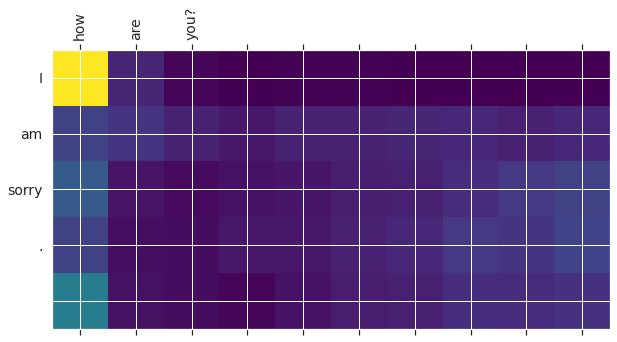

------------------------------
Test replica : how are you?
Bot greedy answer : I am sorry .
Bot beam search answer : Good . good .
Bot nucleus answr : If this can hurt i was something something i
------------------------------


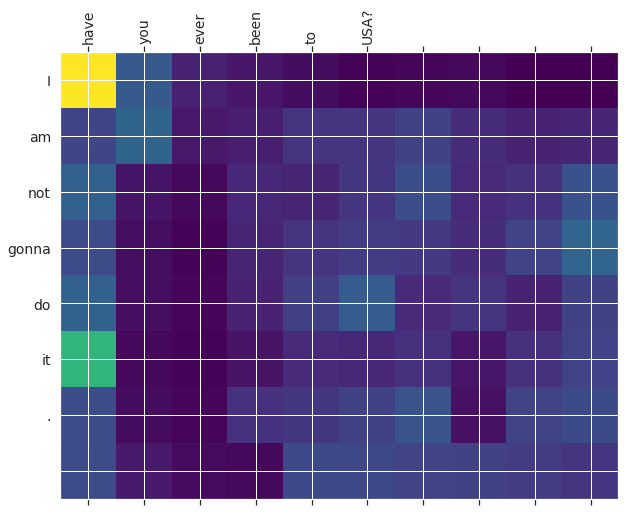

------------------------------
Test replica : have you ever been to USA?
Bot greedy answer : I am not gonna do it .
Bot beam search answer : Yeah .
Bot nucleus answr : How is your mind . i was interested at
------------------------------


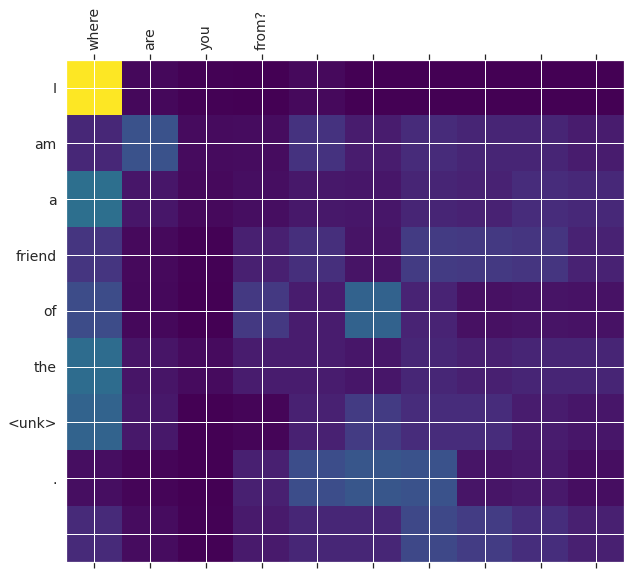

------------------------------
Test replica : where are you from?
Bot greedy answer : I am a friend of the <unk> .
Bot beam search answer : Where are you going ?
Bot nucleus answr : Ok ? my fire .
------------------------------


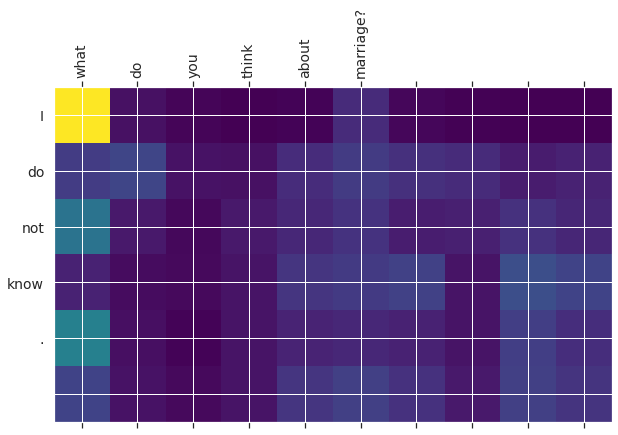

------------------------------
Test replica : what do you think about marriage?
Bot greedy answer : I do not know .
Bot beam search answer : I do not know .
Bot nucleus answr : An ignorant american we could bring this book for
------------------------------


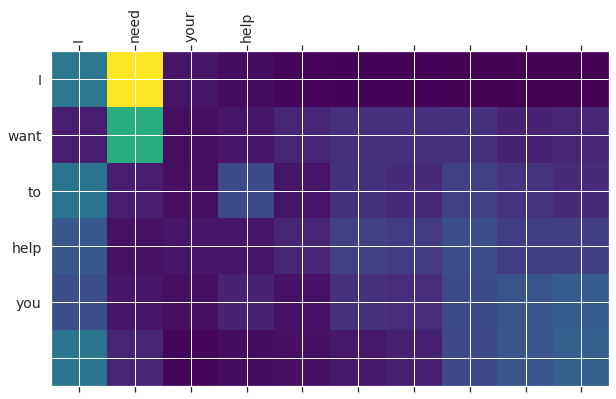

------------------------------
Test replica : I need your help
Bot greedy answer : I want to help you
Bot beam search answer : I want to help you
Bot nucleus answr : I want to stop in or it will be
------------------------------


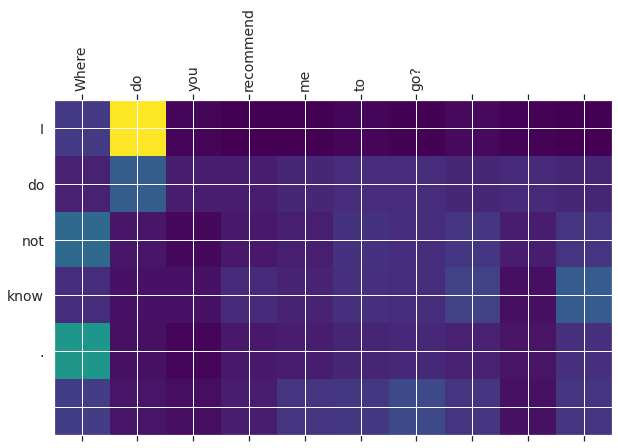

------------------------------
Test replica : Where do you recommend me to go?
Bot greedy answer : I do not know .
Bot beam search answer : I do not know what you are talking about
Bot nucleus answr : Come on me look like <unk> it !
------------------------------


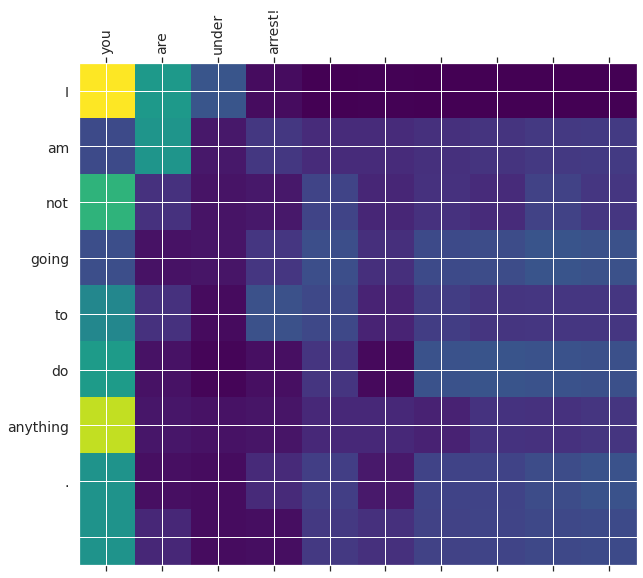

------------------------------
Test replica : you are under arrest!
Bot greedy answer : I am not going to do anything .
Bot beam search answer : You are the only way to get out of
Bot nucleus answr : Will i tell you a fool !
------------------------------


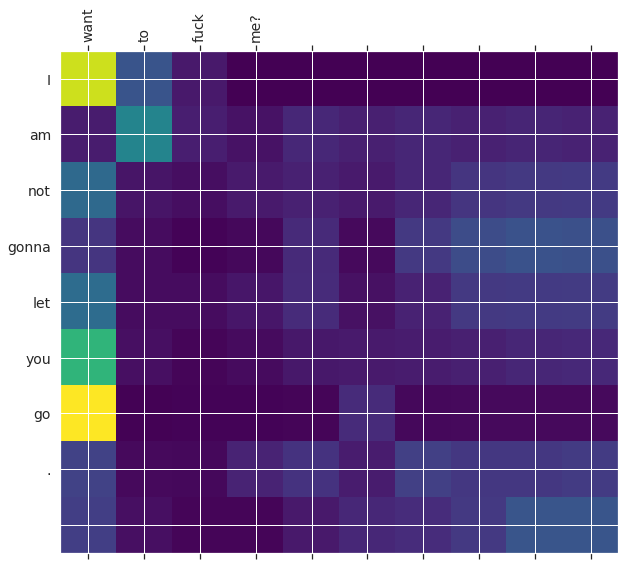

------------------------------
Test replica : want to fuck me?
Bot greedy answer : I am not gonna let you go .
Bot beam search answer : I do not know what you are talking about
Bot nucleus answr : Ask the part . come on here you really
------------------------------


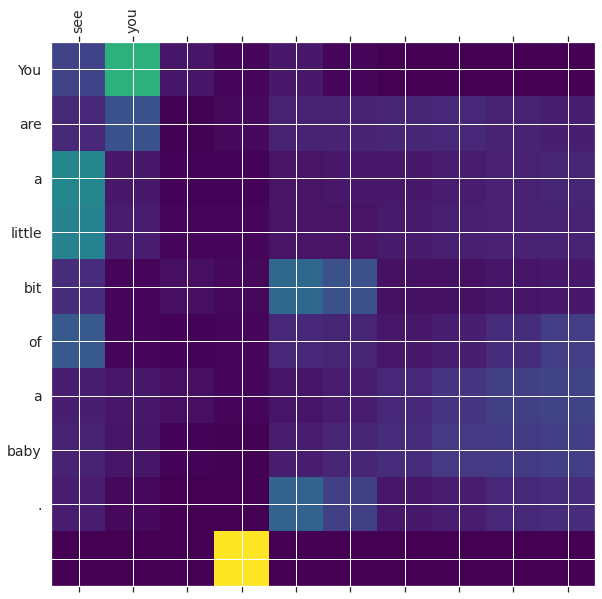

------------------------------
Test replica : see you
Bot greedy answer : You are a little bit of a baby .
Bot beam search answer : You are a little bit of me .
Bot nucleus answr : Come back in order me come here you maggots
------------------------------


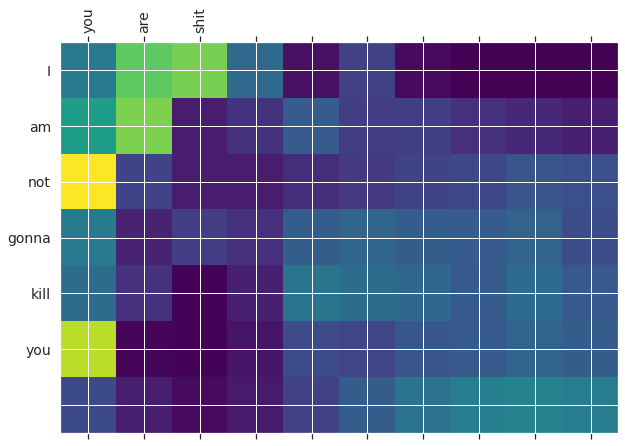

------------------------------
Test replica : you are shit
Bot greedy answer : I am not gonna kill you
Bot beam search answer : I do not know what you are talking about
Bot nucleus answr : Bitch was in some adolescent process about me i
------------------------------


In [28]:
replicas = ['hey you!',
            'hello',
            'hi',
            'how are you?',
            'have you ever been to USA?',
            'where are you from?',
            'what do you think about marriage?',
             'I need your help',
           'Where do you recommend me to go?',
           'you are under arrest!',
           'want to fuck me?',
           'see you',
           'you are shit']
for i in replicas:
    greedy_answer = give_answer(greedy_decoder, i, inverse_token_mapping, show_attention=True)
    beam_search_answer = give_answer(beam_search_decoder, i, inverse_token_mapping,
           beam_search=True,
           beam_size=3)
    nucleus_answer = give_answer(nucleus_decoder, i, inverse_token_mapping, 
                                 nucleus_sampling=True, 
                                 top_p=0.75)
    print(30*'-')
    print('Test replica : {}'.format(i))
    print('Bot greedy answer : {}'.format(greedy_answer))
    print('Bot beam search answer : {}'.format(beam_search_answer))
    print('Bot nucleus answr : {}'.format(nucleus_answer))
    print(30*'-')


# Gabberish dialogue

In [29]:
n_replicas = 100
count = 0
replica = str(input()).strip()
while count<n_replicas:
    replica = give_answer(nucleus_decoder, replica, inverse_token_mapping, 
                                 nucleus_sampling=True, 
                                 top_p=0.95)
    print('\n--- {}'.format(replica))
    count+=1

hi

--- Yuri in particular division consortium within after sunrise 0

--- Il il arrest right proceed may th germany mr.

--- Senator throws she goes below captain wilkins building :

--- Engines checked motor day amongst teeth ! faster out

--- Safe those worry calm get tight rotor loaded behind

--- Pulse show ya cash holes supply plans on ammo

--- Admlral po muscle public market transfer records is entirely

--- Twelve st. distribution his sir doctor louise . power

--- Star navy call chief supports or pedro hunt loose

--- Enigma coursing close balls check colonel supplies two minor

--- Priorities fucking illegal market forward for main magic mountain

--- Row feel hat silent inside put new wardrobe or

--- Bravo on four separate full all week pain speed

--- Shirts room squadron then aragorn dinner tickets if ruben

--- Pittsburgh through massive movie ultrasonics ( marks ready we

--- Virus saruman mr. senator costa down another plate time

--- Presently wait go clean there ? s

# Interactive usage

In [30]:
inp = ''
while True:
    inp = str(input()).strip()
    if inp=='exit':
        break
    greedy_answer = give_answer(greedy_decoder, inp, inverse_token_mapping, show_attention=False)
    beam_search_answer = give_answer(beam_search_decoder, inp, inverse_token_mapping,
           beam_search=True,
           beam_size=7)
    print(30*'-')
    print('Replica : {}'.format(inp))
    print('Beam answer : {}'.format(beam_search_answer))
    print('Greedy answer : {}'.format(greedy_answer))
    print(30*'-')

hello
------------------------------
Replica : hello
Beam answer : It is me .
Greedy answer : I am sorry
------------------------------
why are ypu sorry?
------------------------------
Replica : why are ypu sorry?
Beam answer : What are you doing here ?
Greedy answer : I am not gonna do it .
------------------------------
why are you sorry?
------------------------------
Replica : why are you sorry?
Beam answer : I do not know . it is okay .
Greedy answer : I am not gonna do it .
------------------------------
how old are you?
------------------------------
Replica : how old are you?
Beam answer : Seventeen .
Greedy answer : I am a little bit .
------------------------------
what is your name?
------------------------------
Replica : what is your name?
Beam answer : Lau .
Greedy answer : I am sorry .
------------------------------
where are you from?
------------------------------
Replica : where are you from?
Beam answer : Where are you ?
Greedy answer : I am a friend of the <unk> .


KeyboardInterrupt: Interrupted by user